# `Time series visualization of weather data`

#### import libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from sympy import Eq, Symbol, solve
from scipy import signal

sns.set()
sns.set_context("notebook", font_scale=1.5)

## 1. Load NYC traffic data from Socrata API

In [2]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofnewyork.us", None) 
# Example authenticated client (needed for non-public datasets):
client = Socrata('data.cityofnewyork.us',app_token="LGVsV8LdZ9sOws9dytND8tyaw",
                 username="sunillaudari@gmail.com",
                 password="oxyMoron1915",timeout=3600)
#Fix later to load all years at once

In [3]:
results1 = client.get("7ym2-wayt", limit=1000000,
                     where="yr = '2019'",
                    select="requestid, boro, yr, m, d, hh, mm, Vol")
# Convert to pandas DataFrame
results_df1 = pd.DataFrame.from_records(results1)

In [5]:
results2 = client.get("7ym2-wayt", limit=1000000,
                     where="yr = '2018'",
                    select="requestid, boro, yr, m, d, hh, mm, Vol")
# Convert to pandas DataFrame
results_df2 = pd.DataFrame.from_records(results2)

In [6]:
results3 = client.get("7ym2-wayt", limit=1000000,
                     where="yr = '2017'",
                    select="requestid, boro, yr, m, d, hh, mm, Vol")
# Convert to pandas DataFrame
results_df3 = pd.DataFrame.from_records(results3)

In [7]:
results4 = client.get("7ym2-wayt", limit=1000000,
                     where="yr = '2016'",
                    select="requestid, boro, yr, m, d, hh, mm, Vol")
# Convert to pandas DataFrame
results_df4 = pd.DataFrame.from_records(results4)

In [8]:
results5 = client.get("7ym2-wayt", limit=1000000,
                     where="yr = '2015'",
                    select="requestid, boro, yr, m, d, hh, mm, Vol")
# Convert to pandas DataFrame
results_df5 = pd.DataFrame.from_records(results5)

In [9]:
r1=results_df1.copy()
r2= results_df2.copy()
r3= results_df3.copy()
r4 = results_df4.copy()
r5 = results_df5.copy()

In [15]:
r1.head()

,Vol
date,
2019-01-03,35
2019-01-03,27
2019-01-03,18
2019-01-03,19
2019-01-03,33


## 2. Data Cleaning
- rename columns for clarity
- drop unwanted colmuns
- set datetime index

In [89]:
#if you waant to run the same code under loop:
#for my case, the memory is not sufficiebt 
#results_df1,results_df2,results_df3 = [pd.DataFrame.from_records(client.get("7ym2-wayt", limit=1000000,
#                    where="yr = '{}'".format(i),
#                  select="requestid, boro, yr, m, d, hh, mm, Vol")) for i in ["2019","2018","2017"]

In [10]:
dfs=[r1,r2,r3,r4,r5]
fd=[]
for col in dfs:
    
    col.rename(columns={'yr': 'year', 'm': 'month', 'd': 'day', 'hh': 'hour', 'mm': 'minute'},inplace=True)

    col['date']=pd.to_datetime(col[['year','month','day', 'hour', 'minute']])

    col.sort_values(by="date",inplace=True)

    col.drop(['year', 'month', 'day', 'hour', 'minute','requestid','boro'], axis=1,inplace=True)

    col.set_index('date', inplace=True)

    col["vol"]= col["Vol"].astype("int") # change object to int
    fd.append(pd.DataFrame(col["vol"].resample("D").mean()))

In [11]:
fd1,fd2,fd3,fd4,fd5=fd[0],fd[1],fd[2],fd[3],fd[4]

In [12]:
fd1=fd1.reindex(pd.date_range("2019-01-01","2019-12-31"),fill_value=np.nan)
fd2=fd2.reindex(pd.date_range("2018-01-01","2018-12-31"),fill_value=np.nan)
fd3=fd3.reindex(pd.date_range("2017-01-01","2017-12-31"),fill_value=np.nan)
fd4=fd4.reindex(pd.date_range("2016-01-01","2016-12-31"),fill_value=np.nan)
fd5=fd5.reindex(pd.date_range("2015-01-01","2015-12-31"),fill_value=np.nan)

In [16]:
fd1.head()

,Vol
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,53.904270
2019-01-04,57.209755
2019-01-05,53.254610


## 3. Sample Data for EDA
- check Null values
- interpolate for better visualization
- interpolate all data for rest of the works

In [23]:
fds=[fd1,fd2,fd3,fd4,fd5]
years  = [2019,2018,2017,2016,2015]
for i,j in zip(fds,years):
    print('total nulls in {}: {}'.format(j,i.isna().sum()[0]))

total nulls in 2019: 36
total nulls in 2018: 82
total nulls in 2017: 27
total nulls in 2016: 24
total nulls in 2015: 34


### Interpolate - visualization

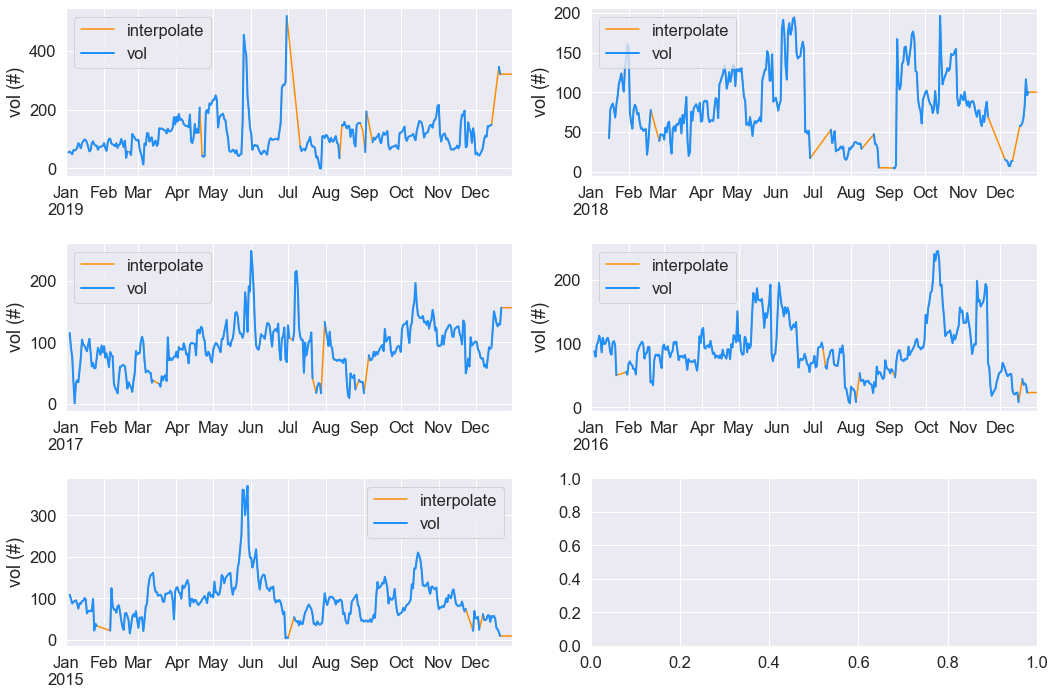

In [51]:
#define number of rows and columns for subplots
nrow=3
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize=(15,10))
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        if r ==2 and c == 1:
            pass
        else:
            fds[count][['vol']].interpolate().plot(ax=axes[r,c], color='darkorange')
            fds[count][['vol']].plot(ax=axes[r,c], lw=2, color= 'dodgerblue')
            axes[r,c].set_ylabel('vol (#)')
            axes[r,c].legend(['interpolate','vol'])
        
        count+=1
plt.tight_layout()

## 4. Interpolate data for rest of the work

In [14]:
finaldf=pd.concat([fd5,fd4,fd3,fd2,fd1])

In [61]:
finaldf.interpolate(inplace=True)
finaldf.backfill(inplace=True) # revise later

In [62]:
finaldf.head()

,vol
2015-01-01,108.514045
2015-01-02,108.514045
2015-01-03,108.514045
2015-01-04,108.514045
2015-01-05,98.512315


In [63]:
finaldf.isna().sum()

vol    0
dtype: int64

## 5. Load NYC weather data

In [64]:
weather=pd.read_csv("New-York-2015-01-01-to-2017-09-24.csv")
weather["datetime"]=pd.to_datetime(weather['datetime'])
weather=weather[["datetime","temp","precip"]]
weather.set_index("datetime",inplace=True)
w16=weather[(weather.index.year==2015) | (weather.index.year==2016)]

In [65]:
weather=pd.read_csv("New-York-2017-01-01-to-2018-12-31.csv")
weather["datetime"]=pd.to_datetime(weather['datetime'])
w18=weather[["datetime","temp","precip"]]
w18.set_index("datetime",inplace=True)

In [66]:
weather=pd.read_csv("New-York-2019-01-01-to-2020-01-01.csv")
weather["datetime"]=pd.to_datetime(weather['datetime'])
weather=weather[["datetime","temp","precip"]]
weather.set_index("datetime",inplace=True)
w19=weather[weather.index.year==2019]

In [67]:
fw=pd.concat([w16,w18,w19])
fw.head()

,temp,precip
datetime,,
2015-01-01,0.3,0.00
2015-01-02,3.5,0.02
2015-01-03,2.0,15.83
2015-01-04,8.9,8.42
2015-01-05,2.4,0.00


### Important features from traffic and weather data (daily)

Features:

- Rainfall indicates the quantity of rain falling (inch)
- Temperature indicates the temperature (°C)

Target:

- Volume indicates the traffic flow in NYC

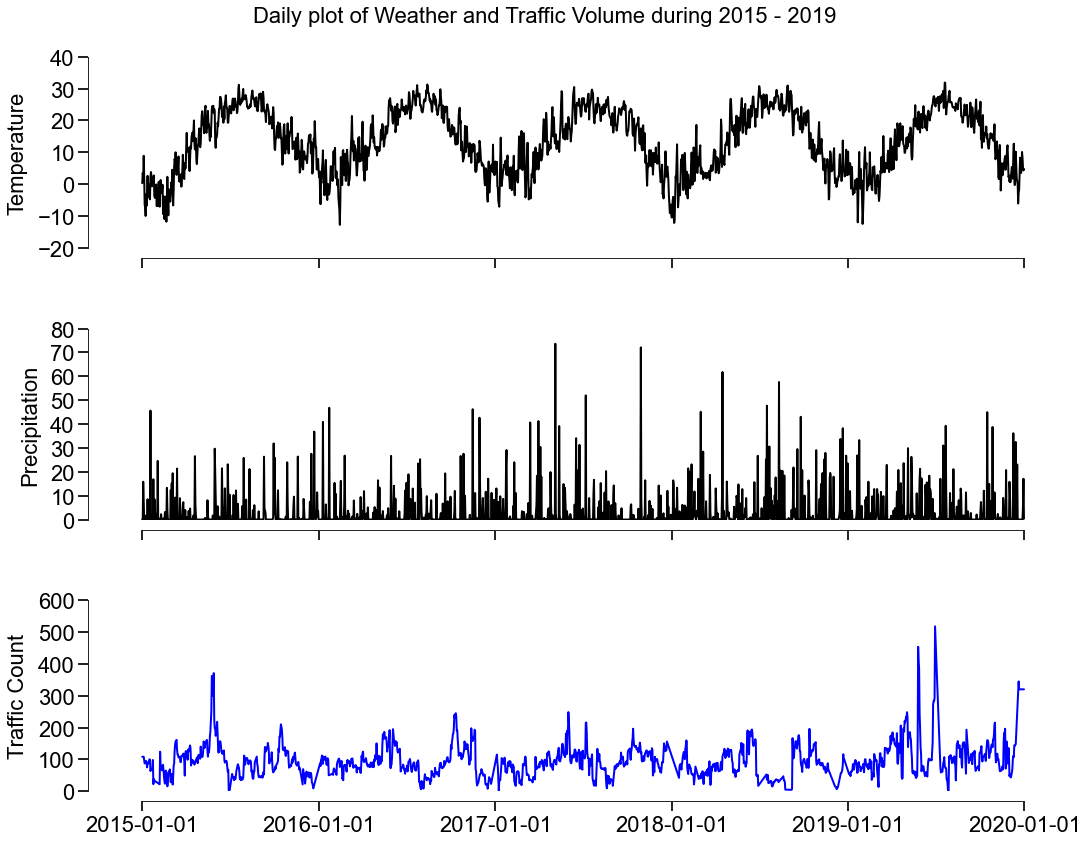

In [69]:
import warnings
import datetime as dt
warnings.filterwarnings("ignore")
sns.set_style(style="ticks")
sns.set_context("paper",font_scale=1.5, rc={"lines.linewidth": 2})
fig, axs = plt.subplots(3, sharex=True, 
                        gridspec_kw={'hspace': 0.2,'height_ratios': [1,1,1]},
                        constrained_layout=True,figsize=(15,11))
fig.suptitle('Daily plot of Weather and Traffic Volume during 2015 - 2019',color="black",
            x=0.5,y=1.05,fontsize=22)
cc=['Temperature','Precipitation','Traffic Count']
                        
data=[fw.temp,fw.precip,finaldf.vol]

color=["black","black","blue"]
                        
                        
for i,c in enumerate(data):
    
    axs[i].plot(fw.index,c,color=color[i])
    axs[i].set_ylabel(cc[i],fontsize=22,labelpad=10,color=color[0])
    
    tkw = dict(size=6, width=2,labelcolor="black")
    axs[i].tick_params(axis='both', labelsize=22,**tkw,direction="in")
    axs[i].tick_params(which='major', length=10,labelcolor="black",direction="out")
    axs[i].tick_params(which='minor', length=5,labelcolor="black",direction="in")
    
    if i ==0:       
        axs[i].set_ylim([-20,40])
        axs[i].set_yticks(np.arange(-20,50,10))
        
    if i ==1:
                
        axs[i].set_ylim([0,80])
        axs[i].set_yticks(np.arange(0,90,10))
        
    if i==2:
                
        axs[i].set_ylim([0,600])
        axs[i].set_yticks(np.arange(0,700,100))
        
#    for xc in [dt.datetime(2016, 1, 1)]:
#        axs[i].axvline(x=xc,ymin=0,ymax=1,ls='--',color='black',linewidth=2.5)
        
        
sns.despine(offset=10, trim=True);        
#label outer
for ax in axs:
    ax.label_outer()
    
#figure description   
fig.tight_layout(pad=2.0) 
plt.show()
#fig.savefig("daily.png",dpi=300,bbox_inches='tight')    

## 6. Monthly Variations
- resampled monthly 
- make plots for features/target

In [70]:
vmonthly=finaldf.resample("M").mean()
wmonthly=fw.resample("M").mean()

In [71]:
dff1=vmonthly[vmonthly.index.year==2015]
dff2=vmonthly[vmonthly.index.year==2016]
dff3=vmonthly[vmonthly.index.year==2017]
dff4=vmonthly[vmonthly.index.year==2018]
dff5=vmonthly[vmonthly.index.year==2019]

In [72]:
wdf1=wmonthly[wmonthly.index.year==2015]
wdf2=wmonthly[wmonthly.index.year==2016]
wdf3=wmonthly[wmonthly.index.year==2017]
wdf4=wmonthly[wmonthly.index.year==2018]
wdf5=wmonthly[wmonthly.index.year==2019]

In [73]:
df1=pd.concat([dff1,wdf1],axis=1)
df2=pd.concat([dff2,wdf2],axis=1)
df3=pd.concat([dff3,wdf3],axis=1)
df4=pd.concat([dff4,wdf4],axis=1)
df5=pd.concat([dff5,wdf5],axis=1)

In [74]:
df2.head()

,vol,temp,precip
2016-01-31,81.498824,1.506452,3.105484
2016-02-29,75.967446,3.213793,3.220345
2016-03-31,82.708621,9.074194,0.967742
2016-04-30,93.919567,11.490000,1.274000
2016-05-31,128.416949,16.877419,2.423871


### Bar and scatter plot for different features/target

<Figure size 432x288 with 0 Axes>

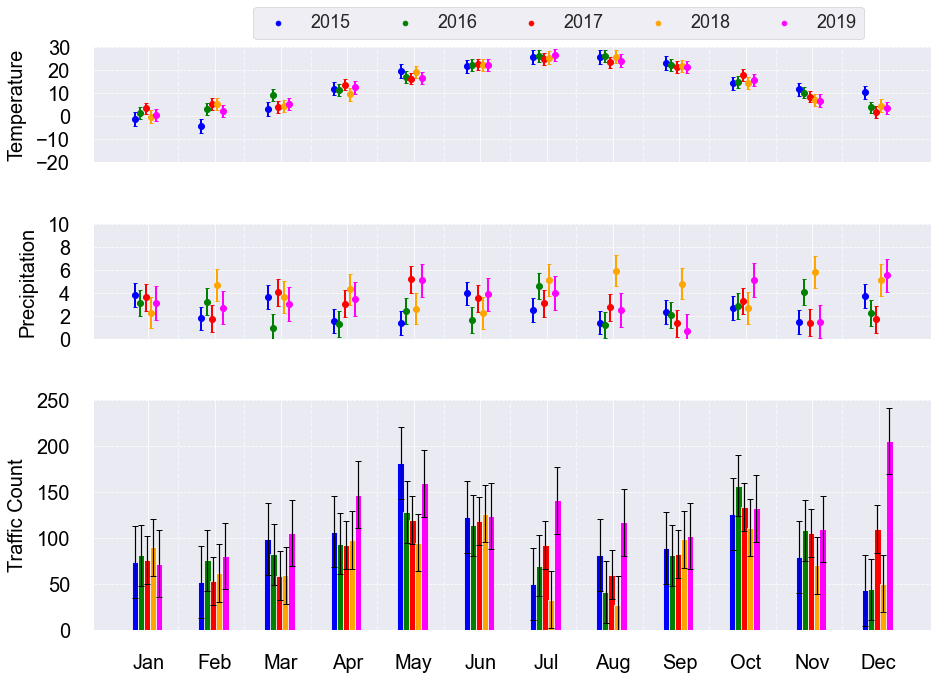

In [78]:
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

#sns.set_style(style="ticks")
sns.despine()
sns.set_context("paper")
dfs=[df1,df2,df3,df4,df5]
fig,axs=plt.subplots(3,1,figsize=(15,12),sharex="col",gridspec_kw={"hspace":0.4,"wspace":0.8,'height_ratios': [1,1,2]})
colors=["blue","green","red","orange","magenta"]
espcolor="aliceblue"
fs=16
labels=["2015","2016","2017","2018","2019"]
for i,ax in enumerate(axs.flat):
    if i==0:
        k,l=1,13
        for j,data in enumerate(dfs):
            xticks=np.arange(k,l)
            ax.scatter(xticks,data["temp"],marker="o",color=colors[j],label=labels[j])
            ax.errorbar(xticks, data["temp"],yerr = data["temp"].std()/np.sqrt(len(data["temp"])), 
               xerr = None,fmt="o",capsize=2,ecolor=colors[j],elinewidth=2,color=colors[j],markersize="6")
            if j==6:
                for m in xticks[:-1]:
                    ax.axvline(x=m+0.2,linestyle="--",color=espcolor)
            
            k+=0.08
            l+=0.08
            ax.legend(loc='center left', bbox_to_anchor=(0.18, 1.21),fontsize=18,ncol=7)
            ax.set_ylabel("Temperature",fontsize=20,labelpad=10,color="black")
            ax.set_ylim([-10,30])
            ax.set_yticks(np.arange(-20,40,10))
    elif i==1:
        k,l=1,13
        for j,data in enumerate(dfs):
            xticks=np.arange(k,l)
            ax.scatter(xticks,data["precip"],marker="o",color=colors[j],label=labels[j])
            ax.errorbar(xticks, data["precip"],yerr = data["precip"].std(), 
                xerr = None,fmt="o",capsize=2,ecolor=colors[j],elinewidth=2,color=colors[j],markersize="6")
            if j==6:
                for m in xticks[:-1]:
                    ax.axvline(x=m+0.2,linestyle="--",color=espcolor)
            k+=0.08
            l+=0.08
            ax.set_ylabel("Precipitation",fontsize=20,labelpad=10,color="black")
           
            ax.set_ylim([0,10])
            ax.set_yticks(np.arange(0,12,2))
    elif i==2:
        k,l=1,13
        for j,data in enumerate(dfs):
            xticks=np.arange(k,l)
            ax.bar(xticks, data["vol"].values, width=0.1, label=labels[i],yerr=data["vol"].std(),
                capsize=3,align='center',ecolor='black',color=colors[j])
            #ax.scatter(xticks,data["Vol"],marker="o",color=colors[j])
            #ax.errorbar(xticks, data["Vol"],yerr = data["Vol"].std()/np.sqrt(len(data["Vol"])), 
             #   xerr = None,fmt="o",capsize=2,ecolor=colors[j],elinewidth=2,color=colors[j],markersize="6")
            if j==6:
                for m in xticks[:-1]:
                    ax.axvline(x=m+0.2,linestyle="--",color=espcolor)  
            k+=0.09
            l+=0.09
            ax.set_xticks(np.arange(1.2,13.2,1))
            ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",
                                "Aug","Sep","Oct","Nov","Dec"],fontsize=20,color="black")
            ax.set_ylabel("Traffic Count",fontsize=20,labelpad=10,color="black")
            ax.set_ylim([0,250])
            #ax.set_yticks([0,0.4,0.8,1.2]
    tkw = dict(size=6, width=2,labelcolor="black")
    ax.tick_params(axis='both', labelsize=20,**tkw,direction="in")
    ax.tick_params(which='major', length=10,labelcolor="black",direction="out")
    ax.tick_params(which='minor', length=5,labelcolor="black",direction="in")
    for xc in np.arange(1.65,12.65,1):
        
        ax.axvline(xc,linestyle="--",color=espcolor)       
    ax.grid(linestyle="--",axis="y")
    #ax.tick_params(axis='both', labelsize=fs)
_ = sns.despine(offset=10, trim=True);
_ = fig.subplots_adjust(top=0.8)
_ = fig.tight_layout(pad=2.0) #lower the pad higher the subplot figures
plt.show()
#fig.savefig('monthlyscatterandbar.png',dpi=300,bbox_inches='tight')

### Monthly variations of rainfall and traffic volumes for different years

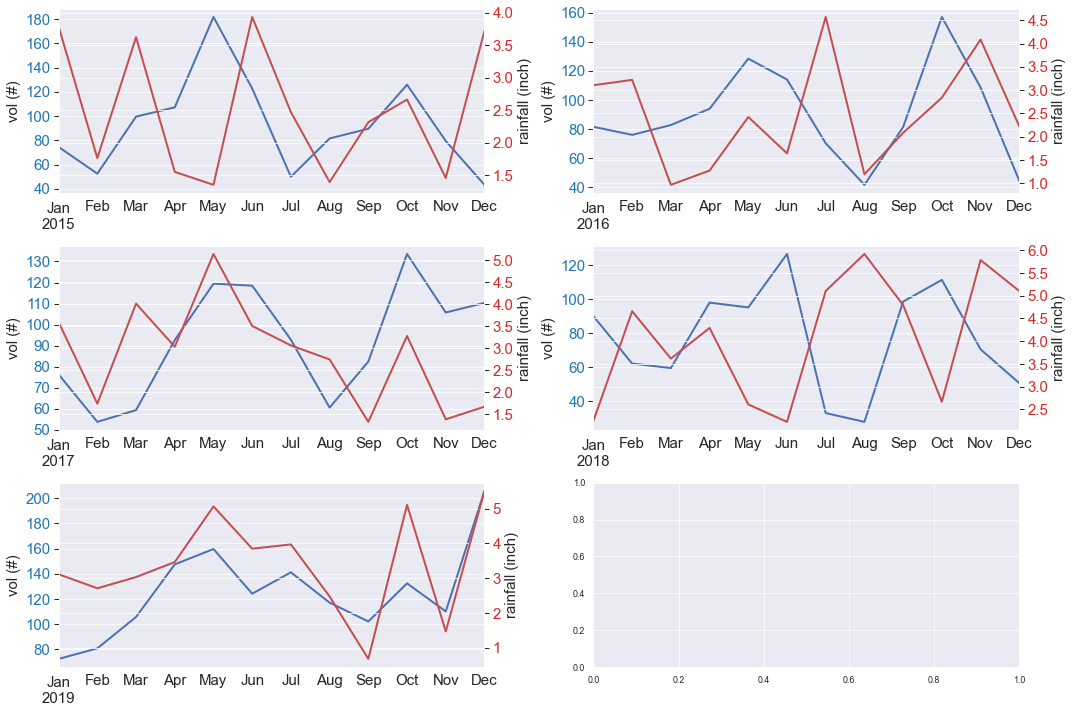

In [81]:
#define number of rows and columns for subplots
nrow=3
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize=(15,10))
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        if r ==2 and c == 1:
            pass
        else:
            color = 'tab:blue'
            dfs[count][['vol']].plot(ax=axes[r,c], lw=2, fontsize=15, legend=False)
            axes[r,c].tick_params(axis='y', labelcolor=color)
            axes[r,c].set_ylabel('vol (#)', fontsize=15)
            ax2 = axes[r,c].twinx()
            dfs[count][['precip']].plot(ax=ax2,lw=2, fontsize=15,color='r', legend=False)
            color = 'tab:red'
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.set_ylabel('rainfall (inch)', fontsize=15)

        count+=1
plt.tight_layout()

- red line is mean temperature that is measured in New York city.
- blue line shows no. of traffic flow at that date.
- As it can be seen from plot, traffic flow is also high at high temperatures.

- can we predict future weather and according to this prediction can we know whether there will be high flow

## 7. Final combined data of weather and traffic_volume
- model data with linear regression
- make prediction

In [101]:
nyc_data=pd.concat([df1,df2,df3,df4,df5])

In [92]:
# Add a constant field for the linear regression
def add_constant(X):
    X['const'] = pd.Series(np.ones(len(X.index)), index=X.index)
    return X

In [103]:
nyc_data['Julian'] = nyc_data.index.to_julian_date()
nyc_data = add_constant(nyc_data)

In [104]:
nyc_data.head()

,vol,temp,precip,Julian,const
2015-01-31,74.528688,-1.190323,3.784516,2457053.5,1.0
2015-02-28,52.489343,-4.328571,1.763214,2457081.5,1.0
2015-03-31,99.556438,3.229032,3.622581,2457112.5,1.0
2015-04-30,107.222782,11.963333,1.551667,2457142.5,1.0
2015-05-31,181.832864,19.506452,1.352581,2457173.5,1.0


### Linear regression Model

- label: temperature

In [114]:
import sklearn.linear_model
import sklearn.metrics

# We can actually train a simple exponential model using the log(value), then train further models on the error.
linear_model = sklearn.linear_model.Ridge().fit( 
    X=nyc_data[['Julian', 'const']], 
    y=nyc_data['vol']
)

linear_model_df = nyc_data
linear_model_df['Linear_Model'] = linear_model.predict(nyc_data[['Julian', 'const']])
linear_model_df['Error'] = nyc_data['vol'] - nyc_data['Linear_Model']

<AxesSubplot:>

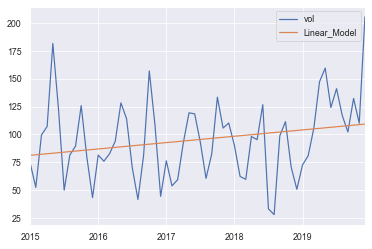

In [115]:
#linear model does not seem quite fit
linear_model_df[['vol', 'Linear_Model']].plot()

- label: precipation

<AxesSubplot:>

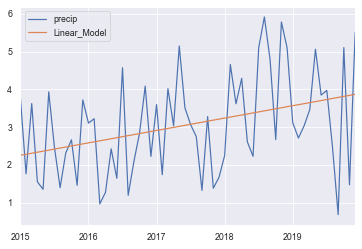

In [112]:
# We can actually train a simple exponential model using the log(value), then train further models on the error.
linear_model = sklearn.linear_model.Ridge().fit( 
    X=nyc_data[['Julian', 'const']], 
    y=nyc_data['precip']
)
linear_model_df = nyc_data
linear_model_df['Linear_Model'] = linear_model.predict(nyc_data[['Julian', 'const']])
linear_model_df['Error'] = nyc_data['precip'] - nyc_data['Linear_Model']
#linear model does not seem quite fit
linear_model_df[['precip', 'Linear_Model']].plot()

## Prediction

In [116]:
## Create a column with "true" (future) values
PREDICTION_LAG = 1 # 1 day only at this moment

# Notice that the goal (what we want to predict) is the vol shifted by the desired period of time.
nyc_data['Actual'] = nyc_data['vol'].shift(-PREDICTION_LAG)

In [129]:
#just for checking; not actual error
nyc_data['Error'] = nyc_data['Error']
### Cross validation -- complex model -- notice that we have overfit!
CUT_MONTH = 10
#Train/Test
train = nyc_data[nyc_data.index.month < CUT_MONTH]
test = nyc_data[nyc_data.index.month >= CUT_MONTH]

In [130]:
# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Error']
    feats['LEE_1'] = frame['Error'].shift(1)
    feats['dLEE_avg'] = pd.Series.rolling(frame['vol'].diff(), window=PREDICTION_LAG).mean()
    feats['vol_avg'] = pd.Series.ewm(frame['vol'], span=10*PREDICTION_LAG).var(bias=False)
    
    feats['Actual_LEE'] = frame['Error'].shift(-PREDICTION_LAG)
    return add_constant(feats)

In [131]:
frame_to_feats(train)[1:-1].head() #1st and last excluded due to nan

,LEE,LEE_1,dLEE_avg,vol_avg,Actual_LEE,const
2015-02-28,-0.026321,-0.006093,-22.039345,242.866355,0.015603,1.0
2015-03-31,0.015603,-0.026321,47.067094,613.636983,0.022081,1.0
2015-04-30,0.022081,0.015603,7.666344,634.395800,0.088795,1.0
2015-05-31,0.088795,0.022081,74.610082,2763.233518,0.035252,1.0
2015-06-30,0.035252,0.088795,-59.023652,1986.855796,-0.030771,1.0


In [132]:
feats = frame_to_feats(train)[1:-1] #again I am excluding 1st and last coz nan values
X_train = feats.drop('Actual_LEE', axis=1).values
y_train = feats['Actual_LEE'].values
regress = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

In [133]:
# Predict
feats = frame_to_feats(test)[1:-1] #again I am excluding 1st and last coz nan values
X_test = feats.drop('Actual_LEE', axis=1).values
y_test = feats['Actual_LEE'].values
feats['Predicted_LEE'] = regress.predict(X_test)


In [134]:
# Reporting function
import scipy as sp
def summarize_errors(test_me):
    error_pct = (test_me['Actual'] - test_me['Model']) / test_me['Actual']

    #print(error_pct.describe())
    error_pct.plot()
    plt.title('% error')
    plt.show()

    error_pct.hist(bins=100, density=True, label = 'Counts')
    x = np.arange(-1, 1, 0.001)
    plt.plot(x, sp.stats.norm(loc=error_pct.mean(),
                              scale=error_pct.std()).pdf(x),
                              linewidth=3, color='red', label='Normal Dist')
    plt.title('Histogram of % errors')
    plt.legend()
    plt.show()

    print(sklearn.metrics.mean_squared_error(test_me['Actual'], test_me['Model']))

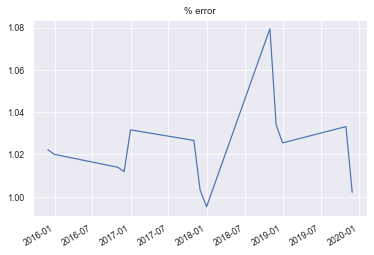

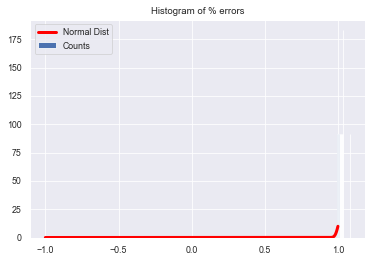

10061.197921909108


In [136]:
test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Simple_Model'] = test['Predicted_LEE'] * test['Linear_Model']

# Report
test_me = test[['Actual', 'Simple_Model']].dropna(how='any') \
                                          .rename(columns={'Simple_Model': 'Model'})
summarize_errors(test_me)